# Visualizing regression models

许多数据集包含多个定量变量，分析的目的通常是将这些变量相互关联。我们之前讨论了可以通过显示两个变量的联合分布来实现这一点的函数。然而，使用统计模型来估计两组嘈杂的观测结果之间的简单关系可能会非常有帮助。本章讨论的函数将通过线性回归的通用框架来实现。

本着Tukey的精神，seaborn 的 regression plots 主要旨在添加一个可视化指南，以帮助在 exploratory data analyses 期间强调数据集中的模式。也就是说，Seaborn 本身并不是统计分析。要获得与回归模型拟合相关的定量度量，您应该使用统计模型。然而，seaborn的目标是通过可视化快速轻松地探索数据集，因为这样做与通过统计表探索数据集一样重要（如果不是更重要的话）。

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_theme(color_codes=True)

In [3]:
tips = sns.load_dataset("tips")

## Functions to draw linear regression models

seaborn 的两个主要函数用于可视化通过回归确定的线性关系。`regplot()` 和 `lmplot()` 密切相关，并共享其大部分核心功能。然而，了解它们的不同方式很重要，以便您可以快速为特定工作选择正确的工具。

在最简单的调用中，两个函数绘制两个变量 `x` 和 `y` 的散点图，然后拟合回归模型 `y ~ x`，并为该回归绘制结果的回归线和95%置信区间：

<AxesSubplot:xlabel='total_bill', ylabel='tip'>

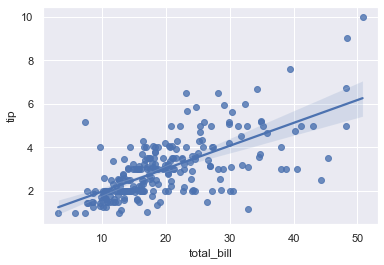

In [4]:
sns.regplot(x="total_bill", y="tip", data=tips)

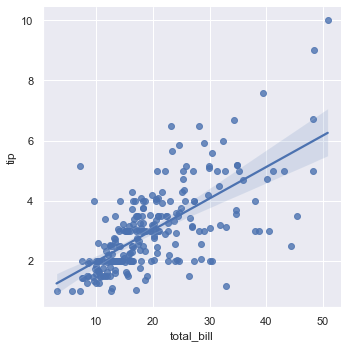

In [5]:
sns.lmplot(x="total_bill", y="tip", data=tips)

您应该注意，生成的绘图是相同的，只是图形形状不同。我们很快就会解释为什么会这样。目前，需要了解的另一个主要区别是，`regplot()` 接受各种格式的 `x` 和 `y` 变量，包括简单的 numpy array、pandas  `Series` 对象，或作为传递给数据的 pandas `DataFrame` 对象中变量的引用。相比之下，`lmplot()` 的 `data` 是必需的参数，`x` 和 `y` 变量必须指定为字符串。这种数据格式被称为 “long-form” 或 "tidy" 数据。除了这种输入灵活性外，`regplot()` 还拥有 `lmplot()` 功能的子集，因此我们将使用后者来演示它们。

当其中一个变量采用离散值时，可以拟合线性回归，然而，此类数据集生成的简单散点图通常不是最佳的：

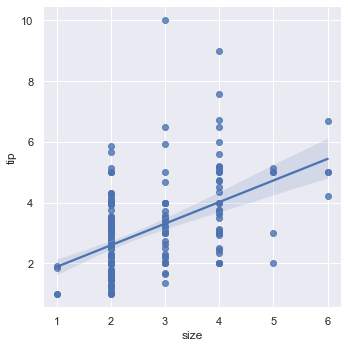

In [6]:
sns.lmplot(x="size", y="tip", data=tips)

一种选择是在离散值中添加一些随机噪声（“jitter”），以使这些值的分布更加清晰。请注意，jitter 仅适用于散点图数据，不影响回归线本身：

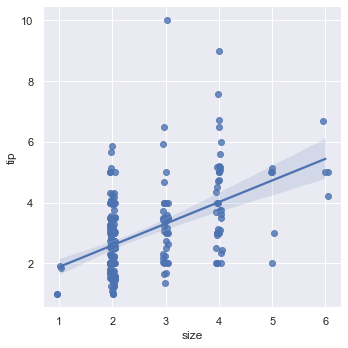

In [7]:
sns.lmplot(x="size", y="tip", data=tips, x_jitter=.05)

第二种选择是 collapse 每个离散 bin 中的观测结果，以绘制中心趋势的估计以及置信区间：

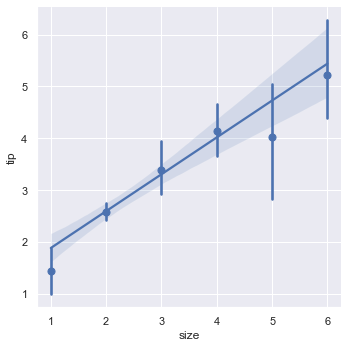

In [8]:
sns.lmplot(x="size", y="tip", data=tips, x_estimator=np.mean)

## Fitting different kinds of models

上面使用的简单线性回归模型非常简单，但不适合某些类型的数据集。Anscombe’s quartet 数据集显示了几个例子，其中简单线性回归提供了对关系的相同估计，其中简单的 visual inspection 清楚地显示了差异。例如，在第一种情况下，线性回归是一个很好的模型：

In [9]:
anscombe = sns.load_dataset("anscombe")

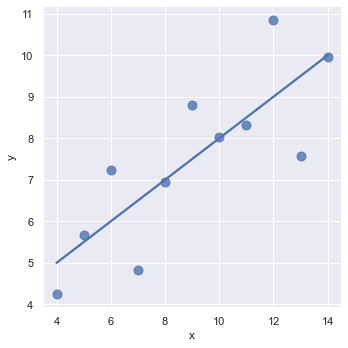

In [10]:
sns.lmplot(x="x", y="y", data=anscombe.query("dataset == 'I'"), ci=None, 
           scatter_kws={"s":80})

第二个数据集中的线性关系是相同的，但绘图清楚地表明这不是一个好模型：

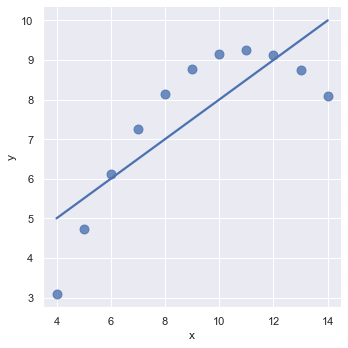

In [11]:
sns.lmplot(x="x", y="y", data=anscombe.query("dataset == 'II'"),
           ci=None, scatter_kws={"s":80})

在存在这种高阶关系的情况下，`lmplot()` 和 `regplot()` 可以拟合多项式回归模型来探索数据集中的简单非线性趋势：

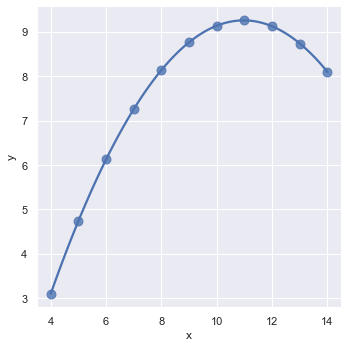

In [12]:
sns.lmplot(x="x", y="y", data=anscombe.query("dataset == 'II'"),
           order=2, ci=None, scatter_kws={"s":80})

“outlier” 观察提出了一个不同的问题，这些观察由于某些原因偏离了正在研究的主要关系：

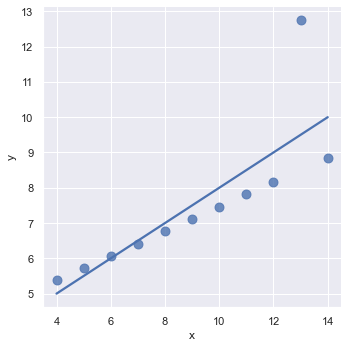

In [13]:
sns.lmplot(x="x", y="y", data=anscombe.query("dataset == 'III'"),
           ci=None, scatter_kws={"s":80})

在存在异常值的情况下，拟合鲁棒回归是有用的，鲁棒回归使用不同的损失函数来降低相对较大的 residuals ：

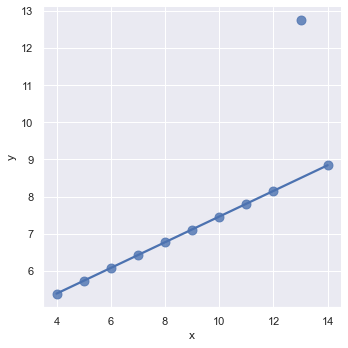

In [14]:
sns.lmplot(x="x", y="y", data=anscombe.query("dataset == 'III'"),
           robust=True, ci=None, scatter_kws={"s" : 80})

当 `y` 变量是二分类时，简单的线性回归也“可行”，但提供了不可信的预测：

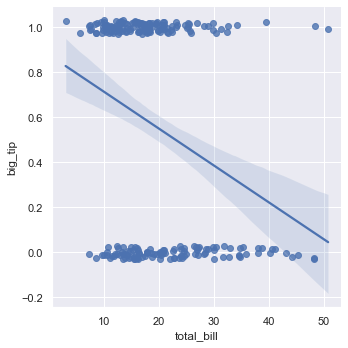

In [16]:
tips["big_tip"] = (tips.tip / tips.total_bill) > .15
sns.lmplot(x="total_bill", y="big_tip", data=tips, y_jitter=.03)

在这种情况下，解决方案是拟合逻辑回归，使得回归线显示给定值 `x` 的估计概率为 `y = 1`：

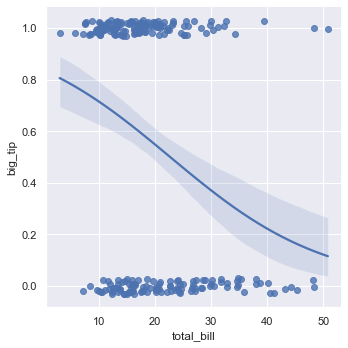

In [19]:
sns.lmplot(x="total_bill", y="big_tip", data=tips, logistic=True, y_jitter=.03)

请注意，逻辑回归估计比简单回归的计算密集度要高得多（鲁棒回归也是如此），由于回归线周围的置信区间是使用 bootstrap procedure 计算的，您可能希望将其关闭以加快迭代（使用 `ci=None` ）。

一个完全不同的方法是使用 ` lowess smoother` 来拟合非参数回归。这种方法的假设最少，它在计算上很密集，因此目前根本没有计算置信区间：

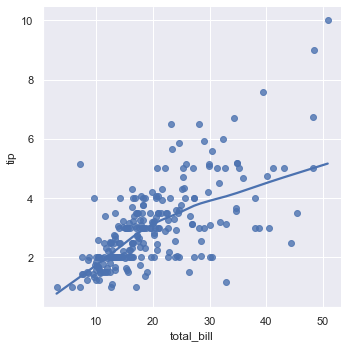

In [20]:
sns.lmplot(x="total_bill", y="tip", data=tips, lowess=True)

`residplot()` 函数可以成为检查简单回归模型是否适合数据集的有用工具。它拟合并删除一个简单的线性回归，然后绘制每个观测的 residual 值。理想情况下，这些值应该随机分布在 `y = 0` 周围：

<AxesSubplot:xlabel='x', ylabel='y'>

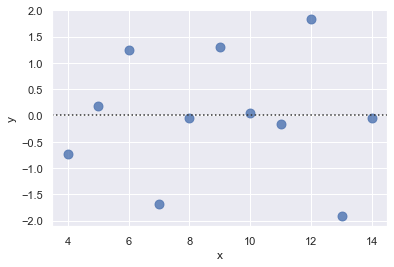

In [21]:
sns.residplot(x="x", y="y", data=anscombe.query("dataset == 'I'"),
              scatter_kws={"s" : 80})

如果 residuals 中有结构，这表明简单的线性回归是不合适的：

<AxesSubplot:xlabel='x', ylabel='y'>

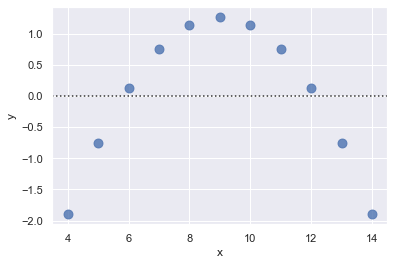

In [23]:
sns.residplot(x="x", y="y", data=anscombe.query("dataset == 'II'"),
              scatter_kws = {"s" : 80})

## Conditioning on other variables

上面的图显示了探索一对变量之间关系的多种方法。然而，通常一个更有趣的问题是“这两个变量之间的关系如何随着第三个变量的函数而变化？” 这就是 `regplot()` 和 `lmplot()` 之间的区别。虽然 `regplot()` 总是显示单个关系，但 `lmplot()` 将 `regplot()` 与 `FacetGrid` 相结合，以提供一个简单的界面，在 “faceted” 绘图上显示线性回归，允许您探索最多三个额外的类别变量的交互。

分离关系的最佳方法是在同一轴上绘制两个级别，并使用颜色来区分它们：

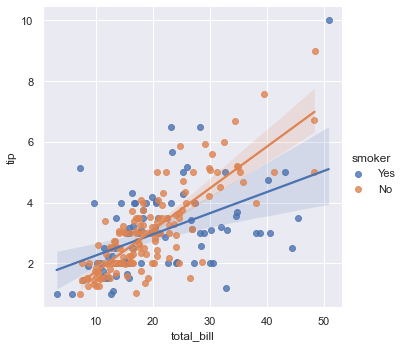

In [24]:
sns.lmplot(x="total_bill", y="tip", hue="smoker", data=tips)

除了颜色外，还可以使用不同的散点图标记，使绘图更好地复制为黑白。您还可以完全控制所使用的颜色：

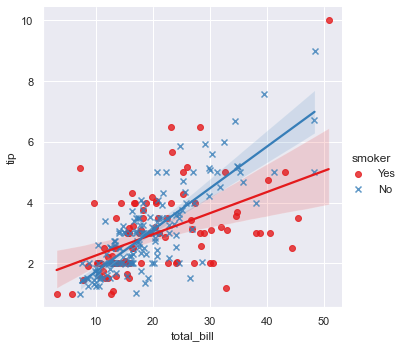

In [25]:
sns.lmplot(x="total_bill", y="tip", hue="smoker", data=tips,
           markers=["o", "x"], palette="Set1")

要添加另一个变量，您可以绘制多个 “facets”，变量的每个级别都出现在网格的行或列中：

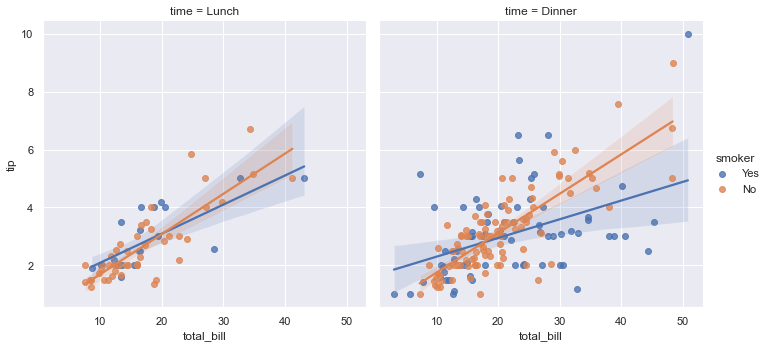

In [28]:
sns.lmplot(x="total_bill", y="tip", hue="smoker", col="time", data=tips)

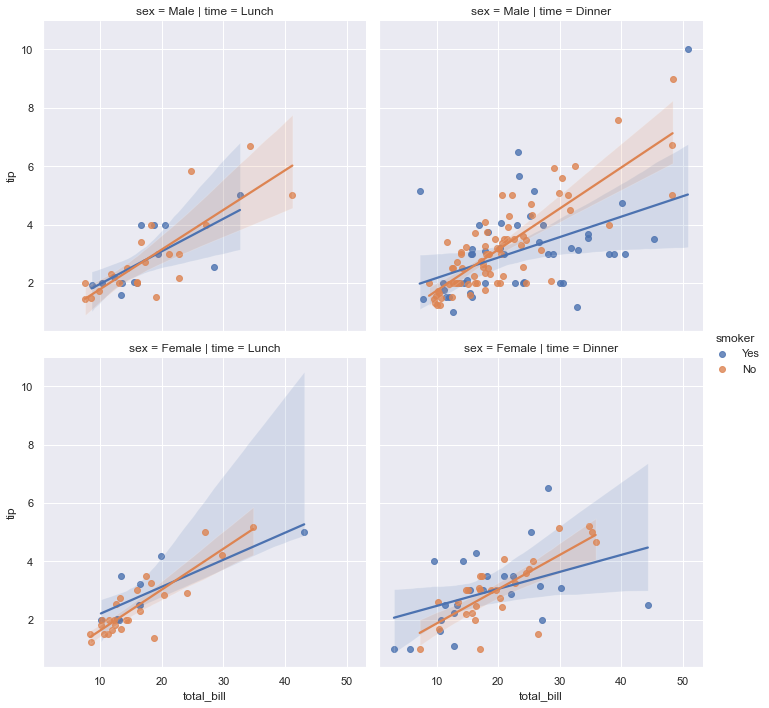

In [29]:
sns.lmplot(x="total_bill", y="tip", hue="smoker", col="time", row="sex", data=tips)

## Controlling the size and shape of the plot

在我们注意到 `regplot()` 和 `lmplot()` 制作的默认绘图看起来相同，但在尺寸和形状不同的轴上。这是因为 `regplot()` 是一个 “axes-level” 函数，可以绘制到特定的轴上。这意味着您可以自己制作 multi-panel figures，并准确控制 regression plot 的去向。如果没有显式提供 axes 对象，它只需使用 “currently active” 轴，这就是为什么默认绘图的大小和形状与大多数其他 matplotlib 函数相同。要控制大小，您需要自己创建一个 figure object。

<AxesSubplot:xlabel='total_bill', ylabel='tip'>

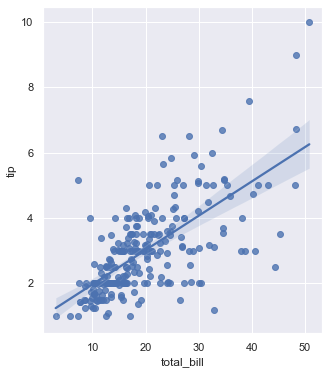

In [30]:
f, ax = plt.subplots(figsize=(5, 6))
sns.regplot(x="total_bill", y="tip", data=tips, ax=ax)

相比之下，`lmplot()` 图形的大小和形状是通过 `FacetGrid` 界面使用 `height` 和 `aspect` 参数控制的，这些参数适用于绘图中的每个方面，而不是整体 figure 本身：

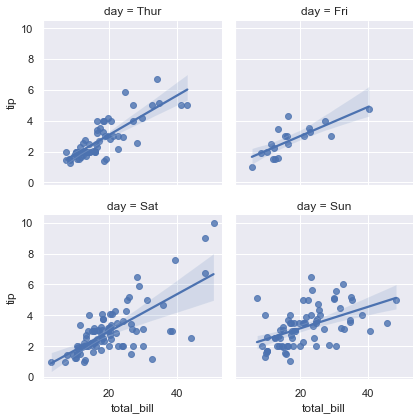

In [31]:
sns.lmplot(x="total_bill", y="tip", col="day", data=tips, col_wrap=2, height=3)

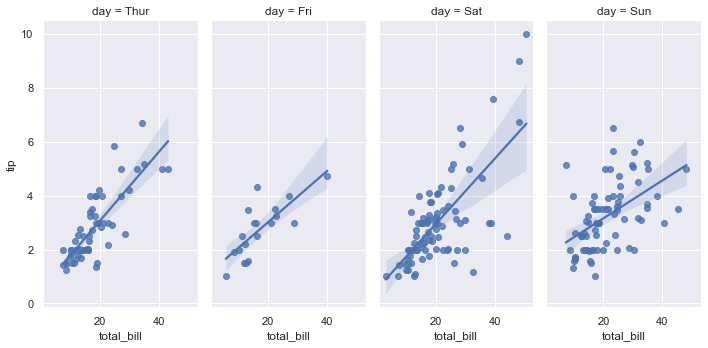

In [32]:
sns.lmplot(x="total_bill", y="tip", col="day", data=tips, aspect=.5)

## Plotting a regression in other contexts

其他一些 seaborn 函数在更大、更复杂的情节中使用 `regplot()`。第一个是我们在 ` distributions tutorial` 中介绍的 `jointplot()` 函数。除了之前讨论的绘图样式外， `jointplot()` 可以使用 `regplot()` 通过传递 `kind="reg"` 来显示  joint axes 上的线性回归拟合：

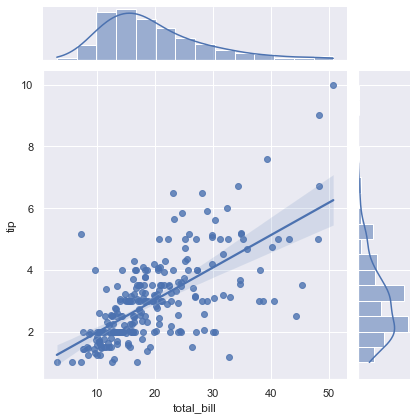

In [33]:
sns.jointplot(x="total_bill", y="tip", data=tips, kind="reg")

将 `pairplot()` 函数与 `kind="reg"` 结合 `regplot()` 和 `PairGrid` 来显示数据集中变量之间的线性关系。注意这与 `lmplot()` 有何不同。在下图中，两个轴不显示以第三个变量的两个级别为条件的相同关系；相反，`PairGrid()` 用于显示数据集中变量的不同配对之间的多个关系：

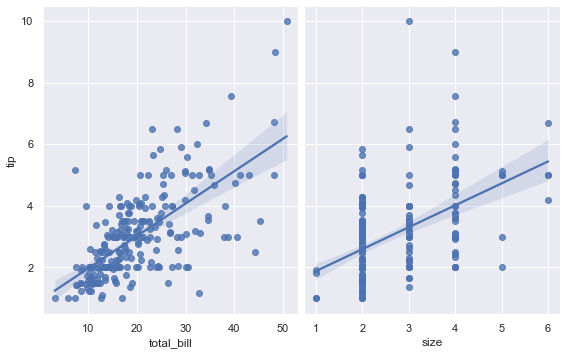

In [35]:
sns.pairplot(tips, x_vars=["total_bill", "size"], y_vars=["tip"],
             height=5, aspect=.8, kind="reg")

与 `lmplot()` 一样，但与 `jointplot()` 不同，使用 `hue` 参数在 `pairplot()` 内建了一个额外的类别变量：

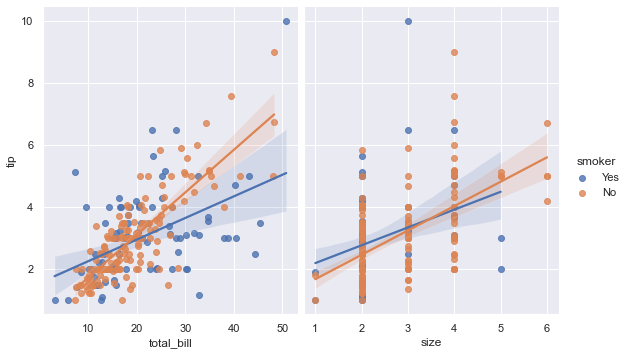

In [36]:
sns.pairplot(tips, x_vars=["total_bill", "size"], y_vars=["tip"],
             hue="smoker", height=5, aspect=.8, kind="reg")